# Dynamic Time Wrapping
# Import Library dan Set Path

kode tersebut berfungsi untuk mendefinisikan pengaturan dasar yang diperlukan dalam proses pembacaan, ekstraksi, dan perbandingan data audio menggunakan metode MFCC dan Dynamic Time Warping. Library seperti os, librosa, numpy, pandas, glob, dan tqdm diimpor untuk membantu operasi file sistem, pemrosesan sinyal audio, perhitungan numerik, pengelolaan data tabular, pencarian file berformat tertentu, dan tampilan progres proses. Variabel SR (sampling rate) ditetapkan sebesar 22050 Hz untuk menentukan kualitas pembacaan audio, dan N_MFCC ditetapkan sebagai 13 untuk mengambil 13 koefisien MFCC dari setiap file audio. OLD_DIRS menyimpan path folder yang berisi data audio lama untuk kategori “buka” dan “tutup”, sedangkan NEW_FILES berisi path file audio baru yang akan dibandingkan. Terakhir, OUT_CSV adalah nama file tempat hasil perhitungan jarak DTW akan disimpan dalam format CSV.

In [14]:
import os
import librosa
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

SR = 22050
N_MFCC = 13
OLD_DIRS = {
    'buka': r'/content/user1/buka',
    'tutup': r'/content/user1/tutup',
}

NEW_FILES = {
    'buka_baru': r'/content/user1/bukabaru.wav',
    'tutup_baru': r'/content/user1/tutupbaru.wav'
}

OUT_CSV = 'dtw_results.csv'


# fungsi extrac dan DTW

kode di bawah terdiri dari dua fungsi utama untuk pemrosesan audio menggunakan MFCC dan perhitungan jarak Dynamic Time Warping (DTW). Fungsi extract_mfcc() bertugas membaca file audio dari path tertentu menggunakan librosa.load dengan sampling rate yang sudah ditentukan dan mengubahnya menjadi mono. Kemudian, fitur MFCC diekstraksi menggunakan librosa.feature.mfcc, dan hasilnya berupa matriks yang mewakili ciri khas suara tersebut. Fungsi kedua, dtw_distance(), mengambil dua matriks MFCC sebagai input (m1 dan m2) dan menghitung jarak antara keduanya menggunakan algoritma DTW dari librosa.sequence.dtw. Fungsi ini menghasilkan matriks biaya kumulatif D dan lintasan pemetaan wp. Nilai jarak mentah (raw cost) diambil dari elemen terakhir matriks D, lalu dibuat normalisasi jarak dengan membagi raw cost terhadap panjang lintasan (path length). Fungsi ini kemudian mengembalikan jarak mentah, jarak ter-normalisasi, dan panjang lintasan DTW sebagai hasil perbandingan kesamaan dua sinyal audio.

In [15]:
def extract_mfcc(path, sr=SR, n_mfcc=N_MFCC):
    y, _ = librosa.load(path, sr=sr, mono=True)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc

def dtw_distance(m1, m2, metric='euclidean'):

    D, wp = librosa.sequence.dtw(X=m1, Y=m2, metric=metric)
    raw = D[-1, -1]
    path_len = len(wp)
    norm = raw / path_len if path_len > 0 else np.inf
    return float(raw), float(norm), int(path_len)



# Collect data lama dan ekstrak mfcc

Potongan kode pertama bertujuan untuk mengumpulkan semua file audio lama (.wav) dari folder yang sudah ditentukan dalam OLD_DIRS. Dengan menggunakan glob, kode mencari semua file dengan ekstensi .wav pada masing-masing folder, lalu menyimpannya dalam dictionary old_files berdasarkan labelnya, yaitu buka dan tutup. Jika tidak ada file yang ditemukan di folder tersebut, program akan menampilkan pesan peringatan. Kemudian, proses ekstraksi MFCC dimulai untuk seluruh file lama. Dictionary old_mfcc dibuat untuk menyimpan hasil ekstraksi MFCC dari setiap file audio lama. Prosesnya dilakukan iteratif per label dan per file, dan tqdm digunakan untuk menampilkan progress bar agar visualisasi proses lebih informatif saat banyak file diproses.

Selanjutnya, bagian kedua kode digunakan untuk mengekstraksi MFCC dari file audio baru (data uji), yang didefinisikan dalam NEW_FILES. Sebelum memproses file baru, program memastikan bahwa file benar-benar ada menggunakan os.path.exists. Jika path file tidak ditemukan, program langsung menghentikan eksekusi dan menampilkan pesan error melalui FileNotFoundError. Setelah file dipastikan ada, MFCC diekstraksi menggunakan fungsi extract_mfcc dan disimpan dalam dictionary new_mfcc. Data MFCC dari file baru ini nantinya akan dibandingkan dengan data MFCC dari file lama menggunakan perhitungan DTW untuk mengukur tingkat kemiripan sinyal audio.

In [16]:
old_files = {}
for label, folder in OLD_DIRS.items():
    pattern = os.path.join(folder, '*.wav')
    files = sorted(glob(pattern))
    if len(files) == 0:
        print(f"~ Peringatan: tidak menemukan file di {folder} (pattern {pattern})")
    old_files[label] = files

print("Ekstrak MFCC untuk data lama...")
old_mfcc = {}
for label, files in old_files.items():
    old_mfcc[label] = {}
    for f in tqdm(files, desc=f"MFCC {label}"):
        old_mfcc[label][f] = extract_mfcc(f)

print("Ekstrak MFCC untuk file baru...")
new_mfcc = {}
for name, path in NEW_FILES.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"File baru tidak ditemukan: {path}")
    new_mfcc[name] = extract_mfcc(path)



Ekstrak MFCC untuk data lama...


MFCC tutup: 100%|██████████| 100/100 [00:01<00:00, 60.32it/s]


Ekstrak MFCC untuk file baru...


# perhitungan DTW

Potongan kode ini melakukan proses inti, yaitu perhitungan jarak antara data audio baru dan data audio lama menggunakan metode Dynamic Time Warping (DTW). Pertama, dibuat list kosong bernama rows untuk menampung hasil perhitungan. Kemudian, melalui tiga lapisan perulangan, setiap file baru (new_feat) dibandingkan dengan seluruh file lama berdasarkan labelnya (buka atau tutup). Dengan bantuan tqdm, progres perhitungan DTW divisualisasikan untuk setiap kombinasi file. Pada tiap iteration, MFCC dari file lama dan file baru diproses oleh fungsi dtw_distance() untuk menghasilkan tiga nilai: raw_cost (biaya kumulatif asli), normalized_cost (biaya DTW yang telah dinormalisasi), dan path_len (panjang jalur DTW). Semua informasi ini disimpan ke dalam dictionary, lalu ditambahkan ke list rows.

Setelah semua pasangan file selesai dihitung, list rows dikonversi menjadi sebuah DataFrame menggunakan pandas untuk memudahkan analisis dan pengolahan data lebih lanjut. DataFrame ini kemudian diekspor menjadi file CSV dengan nama sesuai nilai variabel OUT_CSV (misalnya dtw_results.csv). File CSV yang dihasilkan berisi informasi lengkap tentang jarak DTW antara setiap file baru dan seluruh file lama, termasuk label, path file, nilai jarak, dan panjang jalur DTW. Bagian akhir kode menampilkan pesan konfirmasi bahwa proses perhitungan selesai dan hasil telah berhasil disimpan dalam file CSV.

In [17]:
rows = []
print("Menghitung DTW...")
for new_name, new_feat in new_mfcc.items():
    for label, files in old_files.items():
        for f in tqdm(files, desc=f"DTW {new_name} vs {label}", leave=False):
            m_old = old_mfcc[label][f]
            raw, norm, plen = dtw_distance(m_old, new_feat)
            rows.append({
                'new_file': new_name,
                'old_label': label,
                'old_path': f,
                'raw_cost': raw,
                'normalized_cost': norm,
                'path_len': plen
            })
df = pd.DataFrame(rows)
df.to_csv(OUT_CSV, index=False)
print(f"Hasil tersimpan ke {OUT_CSV}")


Menghitung DTW...


Hasil tersimpan ke dtw_results.csv


# kemiripan data lama dan baru
Potongan kode ini digunakan untuk menampilkan 5 file lama yang paling mirip dengan setiap file baru berdasarkan hasil perhitungan DTW. Dengan mengambil data unik dari kolom new_file, kode memproses setiap file baru satu per satu. Untuk masing-masing file baru, dibuat subset DataFrame (sub) yang hanya berisi baris yang relevan, lalu diurutkan berdasarkan nilai normalized_cost dari yang terkecil. Nilai normalized cost yang lebih rendah menunjukkan tingkat kemiripan yang lebih tinggi. Kemudian, kode mencetak nama file baru sebagai judul dan menampilkan 5 baris teratas yang memuat informasi old_label (kategori buka/tutup), old_path (lokasi file lama), serta normalized_cost. Fungsi to_string(index=False) digunakan agar output lebih bersih tanpa menampilkan index DataFrame.

In [12]:
print("\nTop 5 file lama paling mirip untuk setiap file baru:")
for new_name in df['new_file'].unique():
    sub = df[df['new_file'] == new_name].sort_values('normalized_cost')
    print(f"\n== {new_name} ==")
    print(sub[['old_label','old_path','normalized_cost']].head(5).to_string(index=False))



Top 5 file lama paling mirip untuk setiap file baru:

== buka_baru ==
old_label                           old_path  normalized_cost
     buka /content/user1/buka/buka1 (73).wav        91.758524
     buka /content/user1/buka/buka1 (72).wav        98.709102
     buka /content/user1/buka/buka1 (74).wav        99.691555
     buka /content/user1/buka/buka1 (90).wav       100.296021
     buka /content/user1/buka/buka1 (77).wav       102.924713

== tutup_baru ==
old_label                           old_path  normalized_cost
     buka /content/user1/buka/buka1 (73).wav       104.339551
     buka /content/user1/buka/buka1 (77).wav       109.091945
     buka /content/user1/buka/buka1 (71).wav       113.872330
     buka /content/user1/buka/buka1 (74).wav       115.523999
     buka /content/user1/buka/buka1 (72).wav       115.802941


# Visualisasi

kode ini digunakan untuk membuat berbagai visualisasi hasil perhitungan jarak DTW agar analisis kemiripan audio menjadi lebih mudah dipahami. Pertama, dibuat visualisasi berupa diagram batang (bar chart) yang menampilkan rata-rata normalized cost antara masing-masing file baru dengan dua kelas data lama (buka dan tutup). Grafik ini memberikan gambaran secara umum kelas mana yang lebih mirip dengan file baru berdasarkan nilai cost terendah. Selanjutnya, kode membuat histogram untuk menampilkan distribusi nilai normalized cost pada setiap kelas data lama, sehingga kita dapat melihat penyebaran dan variasi jarak DTW, apakah datanya homogen (nilai cost mirip satu sama lain) atau heterogen (nilai cost bervariasi besar). Kemudian, dibuat juga scatter plot, yang menunjukkan sebaran semua nilai normalized cost berdasarkan indeks file lama. Visualisasi ini membantu mengidentifikasi file mana yang memiliki jarak paling kecil atau paling besar terhadap file baru.

Bagian terakhir dari kode adalah visualisasi paling mendalam, yakni DTW Warp Path (Alignment) untuk pasangan file baru dengan file lama paling mirip (nilai normalized cost terkecil). Pertama, kode mencari file lama terbaik (best match), lalu menghitung ulang DTW untuk kedua file tersebut. Matriks cumulative cost ditampilkan dalam bentuk heatmap menggunakan plt.imshow, dengan warp path (jalur penyelarasan) digambar menggunakan garis berwarna kuning. Jalur ini memperlihatkan bagaimana dua sinyal audio disejajarkan secara dinamis dari waktu ke waktu. Visualisasi ini sangat penting untuk memahami bagaimana DTW menyelaraskan perbedaan kecepatan pengucapan atau durasi antara dua audio, bukan hanya menunjukkan seberapa mirip mereka secara numerik.


Menyiapkan visualisasi...


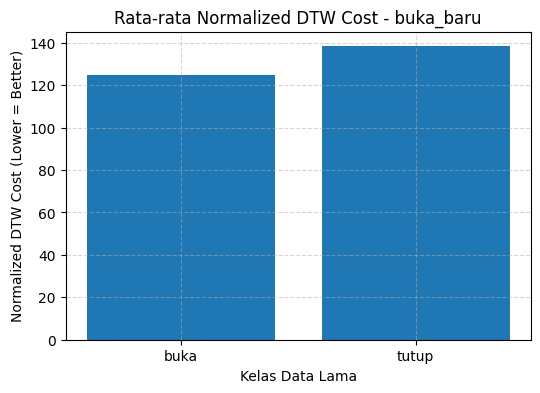

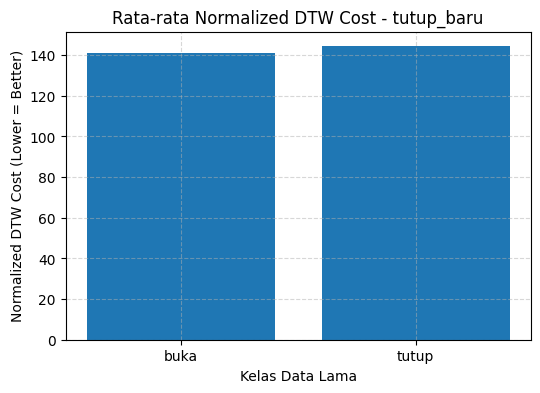

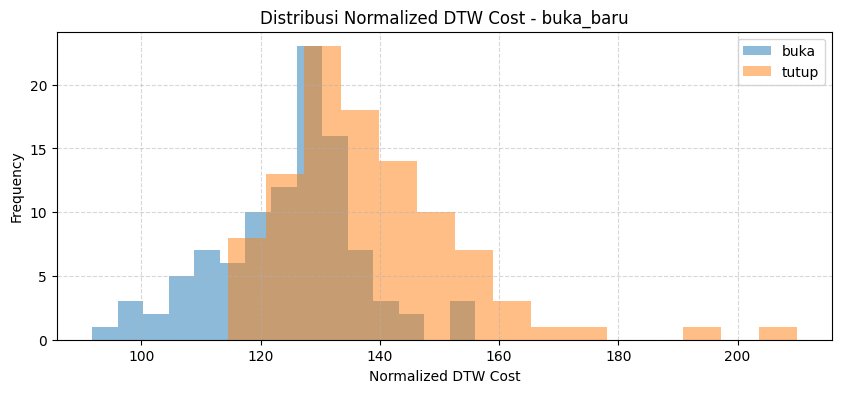

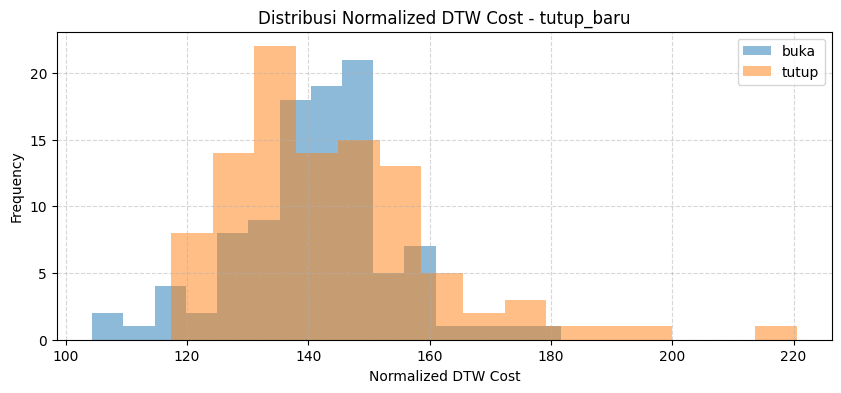

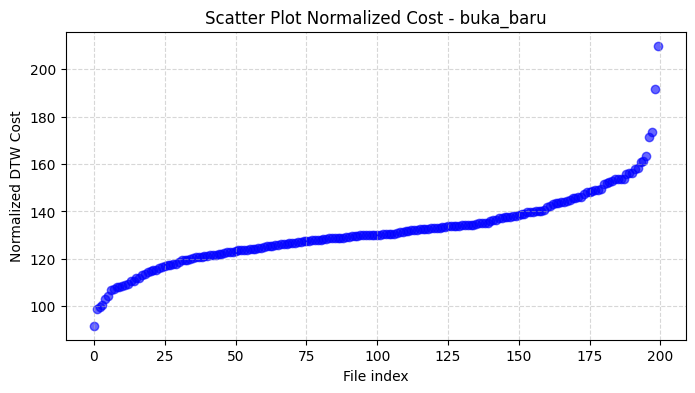

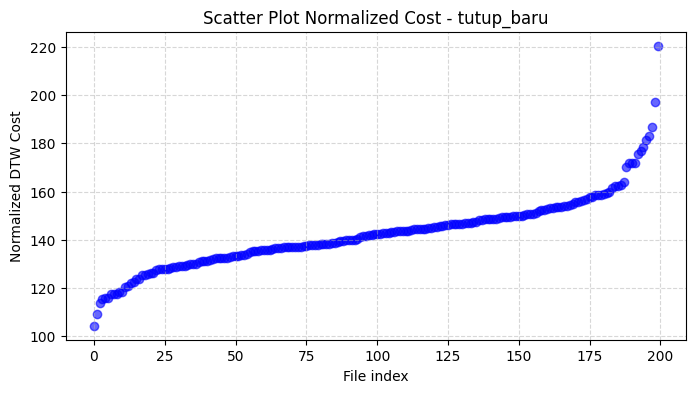


Visualisasi Warp Path (DTW Alignment) untuk file paling mirip:

DTW Alignment buka_baru vs /content/user1/buka/buka1 (73).wav


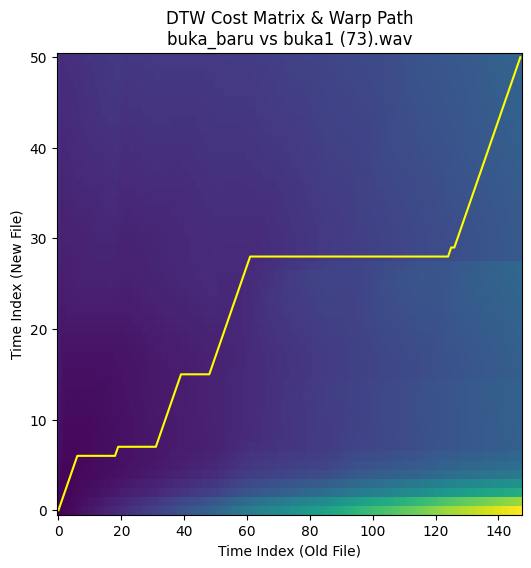


DTW Alignment tutup_baru vs /content/user1/buka/buka1 (73).wav


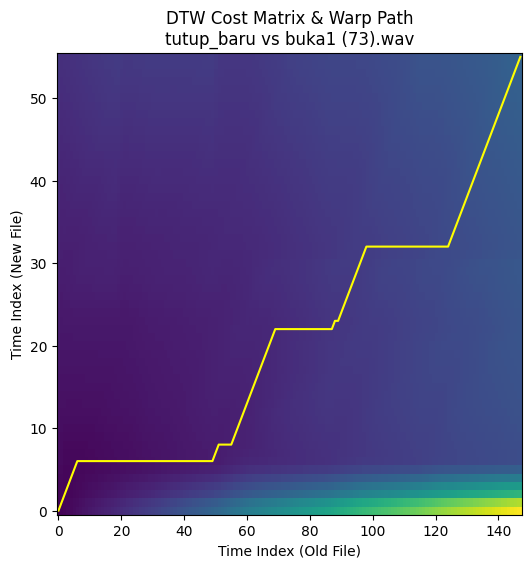

In [13]:
import matplotlib.pyplot as plt

print("\nMenyiapkan visualisasi...")

summary = df.groupby(['new_file', 'old_label'])['normalized_cost'].mean().reset_index()

for new_name in df['new_file'].unique():
    s2 = summary[summary['new_file'] == new_name]

    plt.figure(figsize=(6,4))
    plt.bar(s2['old_label'], s2['normalized_cost'])
    plt.title(f"Rata-rata Normalized DTW Cost - {new_name}")
    plt.ylabel("Normalized DTW Cost (Lower = Better)")
    plt.xlabel("Kelas Data Lama")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

for new_name in df['new_file'].unique():
    plt.figure(figsize=(10,4))
    for label in df['old_label'].unique():
        subset = df[(df['new_file'] == new_name) & (df['old_label'] == label)]['normalized_cost']
        plt.hist(subset, bins=15, alpha=0.5, label=label)

    plt.title(f"Distribusi Normalized DTW Cost - {new_name}")
    plt.xlabel("Normalized DTW Cost")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

for new_name in df['new_file'].unique():
    sub = df[df['new_file'] == new_name].sort_values('normalized_cost')

    plt.figure(figsize=(8,4))
    plt.scatter(range(len(sub)), sub['normalized_cost'], c='blue', alpha=0.6)
    plt.title(f"Scatter Plot Normalized Cost - {new_name}")
    plt.xlabel("File index")
    plt.ylabel("Normalized DTW Cost")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

print("\nVisualisasi Warp Path (DTW Alignment) untuk file paling mirip:")
for new_name in df['new_file'].unique():
    best_match = df[df['new_file'] == new_name].sort_values('normalized_cost').iloc[0]
    best_old_file = best_match['old_path']

    print(f"\nDTW Alignment {new_name} vs {best_old_file}")

    m_new = new_mfcc[new_name]
    m_old = old_mfcc[best_match['old_label']][best_old_file]

    D, wp = librosa.sequence.dtw(X=m_old, Y=m_new)

    plt.figure(figsize=(6,6))
    plt.imshow(D.T, origin='lower', aspect='auto', interpolation='nearest')
    plt.plot([p[0] for p in wp], [p[1] for p in wp], color='yellow')
    plt.title(f"DTW Cost Matrix & Warp Path\n{new_name} vs {os.path.basename(best_old_file)}")
    plt.xlabel("Time Index (Old File)")
    plt.ylabel("Time Index (New File)")
    plt.show()
